Data loaded: 22340 samples
Duration: 202.7 seconds
Columns: ['t', 'x', 'y', 'z', 'time_ms', 'norm', 'x_mavg', 'y_mavg', 'z_mavg', 'norm_mavg', 'pitch', 'roll', 'x_sg', 'time_s']
PAUSES
Pause from 20.4s to 23.4s: 320 samples
Pause from 69.8s to 75.0s: 572 samples
Pause from 111.9s to 116.1s: 462 samples
Pause from 166.3s to 170.4s: 450 samples

Total pause samples: 1804
Total rumination samples: 20536

Created windows:
Pause: 338 windows
Rumination: 684 windows

--- Testing fold 1 of 4 ---
Accuracy: 99.2%

Detailed results:
              precision    recall  f1-score   support

       Pause       0.98      1.00      0.99        85
  Rumination       1.00      0.99      0.99       171

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256


--- Testing fold 2 of 4 ---
Accuracy: 98.0%

--- Testing fold 3 of 4 ---
Accuracy: 96.9%

--- Testing fold 4 of 4 ---
Accuracy: 96.5%

FINAL RE

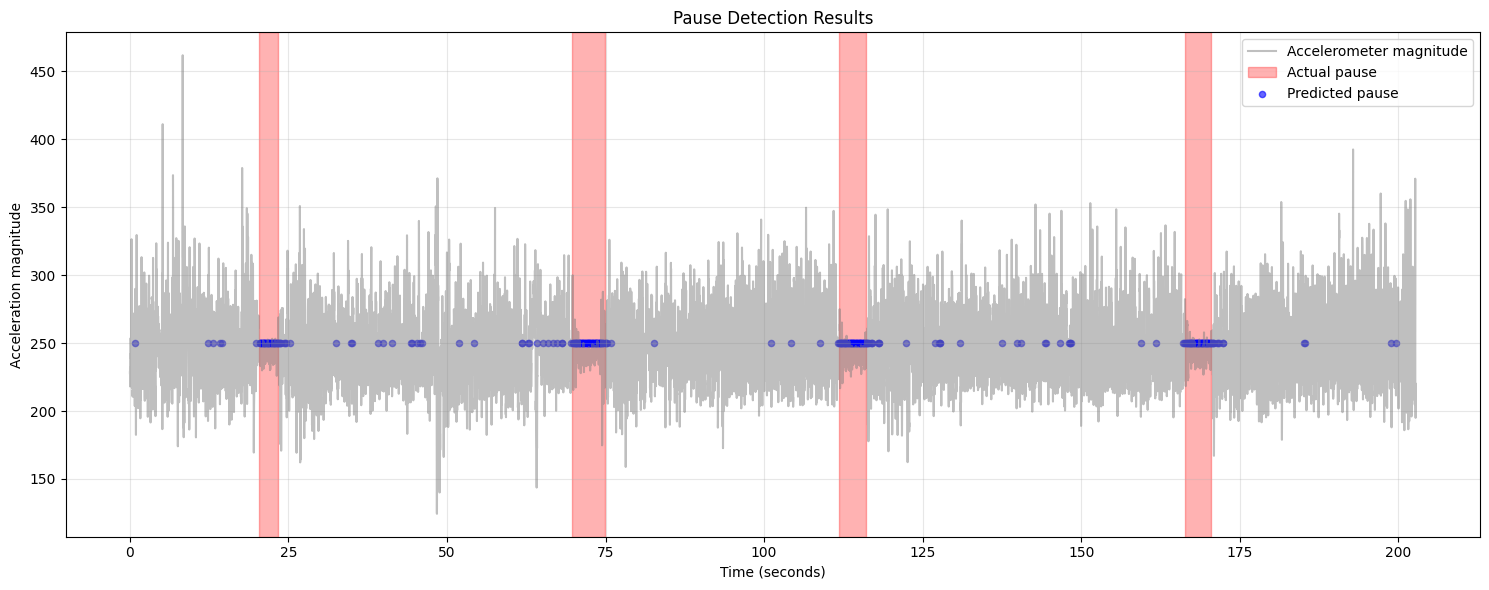

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

acc = pd.read_csv(r"C:\Users\eleut\OneDrive\Desktop\Cow during rumination\video2\segment_01.csv" )
acc['time_s'] = acc['time_ms'].astype(float) / 1000.0

print(f"Data loaded: {len(acc)} samples")
print(f"Duration: {acc['time_s'].max():.1f} seconds")
print(f"Columns: {acc.columns.tolist()}")
# Which sensor readings to use
features = ['x', 'y', 'z', 'norm', 'pitch', 'roll']

# Time periods where the cow paused
pause_segments = [
    (20.36, 23.35), 
    (69.76, 74.97),   
    (111.87, 116.09), 
    (166.33, 170.43)  
]

acc['phase'] = 1  # 1 = ruminating, 0 = pause

print("PAUSES")
for start, end in pause_segments:
    mask = (acc['time_s'] >= start) & (acc['time_s'] <= end)
    acc.loc[mask, 'phase'] = 0
    print(f"Pause from {start:.1f}s to {end:.1f}s: {mask.sum()} samples")

print(f"\nTotal pause samples: {(acc['phase']==0).sum()}")
print(f"Total rumination samples: {(acc['phase']==1).sum()}")


# TRAINING
def create_balanced_windows(acc, window_size=30, pause_stride=5, rumin_stride=30):
    """
    Split the data into small chunks (windows) for the CNN to analyze
    window_size=30: Each window is 0.3 seconds (at 100Hz)
    pause_stride=5: High overlap for pauses
    rumin_stride=30: Less overlap for rumination
    """
    
    X_pause, X_rumin = [], []
    
    # Get windows from PAUSE periods
    # Use small stride (5) to create many overlapping windows
    for start, end in pause_segments:
        pause_data = acc[(acc['time_s'] >= start) & (acc['time_s'] <= end)]
        if len(pause_data) < window_size:
            continue
        
        data = pause_data[features].values
        for i in range(0, len(data) - window_size, pause_stride):
            X_pause.append(data[i:i+window_size])
    
    # Get windows from RUMINATION periods  
    # Use larger stride (30) because we have lots of rumination data
    rumin_data = acc[acc['phase'] == 1][features].values
    for i in range(0, len(rumin_data) - window_size, rumin_stride):
        X_rumin.append(rumin_data[i:i+window_size])
    
    # Balance the classes
    # beacuse if we have 1000 rumination and 100 pause examples,
    # the model will just predict "rumination" always
    max_rumin = len(X_pause) * 3  #
    if len(X_rumin) > max_rumin:
        # Randomly pick which rumination windows to keep
        indices = np.random.choice(len(X_rumin), max_rumin, replace=False)
        X_rumin = [X_rumin[i] for i in indices]
    
    print(f"\nCreated windows:")
    print(f"Pause: {len(X_pause)} windows")
    print(f"Rumination: {len(X_rumin)} windows")
    
    X = np.array(X_pause + X_rumin)
    y = np.array([0]*len(X_pause) + [1]*len(X_rumin))
    
    # Normalization
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-6)
    
    return X, y

# model
class PauseDetectorNet(nn.Module):
    """
    Simple CNN that looks at accelerometer patterns
    
    Why CNN? Convolutional layers are good at finding patterns
    like "sudden drop in movement" or "rhythmic motion"
    """
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
       
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # classifier
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),  # randomly ignore neurons to prevent memorizing
            nn.Linear(32, 2)  # output: pause or rumination
        )
        
    def forward(self, x):
        # Rearrange data for Conv1d
        x = x.transpose(1, 2)
        
        # Find patterns
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Summarize and classify
        x = self.pool(x).squeeze(-1)
        return self.fc(x)


# Prepare the data
X, y = create_balanced_windows(acc)

# 4-fold cross validation
# Split data into 4 parts, train on 3, test on 1, repeat 4 times
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
fold_scores = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\n--- Testing fold {fold+1} of 4 ---")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Convert to PyTorch format
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.LongTensor(y_train)
    X_test_t = torch.FloatTensor(X_test)
    
    # Create fresh model for this fold
    model = PauseDetectorNet()
    
    # Loss function with weights
    # Why weights? We care more about finding pauses (rarer class)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([2.0, 1.0]))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train for 100 iterations
    for epoch in range(100):
        # Forward pass
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Test on this fold
    with torch.no_grad():
        predictions = model(X_test_t).argmax(dim=1).numpy()
        accuracy = (predictions == y_test).mean()
        fold_scores.append(accuracy)
        print(f"Accuracy: {accuracy:.1%}")
        
        # Show detailed results for first fold
        if fold == 0:
            print("\nDetailed results:")
            print(classification_report(y_test, predictions, 
                                      target_names=['Pause', 'Rumination']))

# Show overall performance
print(f"\nFINAL RESULTS")
print(f"Average accuracy: {np.mean(fold_scores):.1%} ± {np.std(fold_scores):.1%}")

print("\nCreating visualization...")

# Apply model to entire recording
with torch.no_grad():
    all_windows = []
    window_times = []
    
    # Slide a window across all data
    for i in range(0, len(acc) - 30, 10):  # Step by 10 samples (0.1s)
        window = acc.iloc[i:i+30][features].values
        all_windows.append(window)
        window_times.append(acc.iloc[i+15]['time_s'])  # Time at window center
    
    # Normalize
    all_windows = np.array(all_windows)
    all_windows = (all_windows - all_windows.mean(axis=0)) / (all_windows.std(axis=0) + 1e-6)
    
    # Predict
    predictions = model(torch.FloatTensor(all_windows)).argmax(dim=1).numpy()

# Plot results
plt.figure(figsize=(15, 6))

# Show accelerometer magnitude
plt.plot(acc['time_s'], acc['norm'], 'gray', alpha=0.5, label='Accelerometer magnitude')

# Show actual pauses in red
for i, (start, end) in enumerate(pause_segments):
    plt.axvspan(start, end, alpha=0.3, color='red', 
                label='Actual pause' if i==0 else '')

# Show predicted pauses as blue dots
pause_predictions = [window_times[i] for i in range(len(predictions)) if predictions[i] == 0]
if pause_predictions:
    plt.scatter(pause_predictions, [250]*len(pause_predictions), 
                c='blue', s=20, label='Predicted pause', alpha=0.6)

plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration magnitude')
plt.title('Pause Detection Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


